更新信息

In [1]:
'''
2019-3-19：发布。
'''

'\n2019-3-19：发布。\n'

In [2]:
#运行自定义函数文件，导入函数
%run /home/kesci/input/score_card_func8159/custom_score_card_func_v2.py

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
from statsmodels.api import Logit
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


读取数据

In [4]:
path_file='/home/kesci/input/b_card8893/'
#数据来自国内某银行信用卡，有扰动（提供完全真实数据是不可能的）
train_data=pd.read_csv(path_file+'traindata.csv')#训练集
test_data=pd.read_csv(path_file+'testData.csv')#测试集
train_data[:2]

,CUST_ID,Loan_Amount,OS_0,OS_1,OS_2,OS_3,OS_4,OS_5,OS_6,OS_7,...,Delq3_4,Delq3_5,Delq3_6,Delq3_7,Delq3_8,Delq3_9,Delq3_10,Delq3_11,Delq3_12,label
0,5f97c74f9eee425083c9535536c96f75,90000,25947.77,86565.62,112978.46,41926.58,81568.91,40556.02,40700.32,53312.53,...,0,0,0,0,0,0,0,0,0,0
1,892a7cdc80e348a8b4f38ac88cf78698,180000,99887.21,99887.21,17689.21,54578.30,108546.73,177679.61,122616.69,26987.69,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_data.info()#无缺失，数据类型ok
'''
OS_n：截止第n期末欠款总额；Payment_n：第n期还款额；Spend_n：第n期使用使用额度；
OS_n+1 = OS_n + Spend_n - Payment_n；

Delq1_n：第n期是否出现M0逾期；Delq2_n：第n期是否出现M1逾期；Delq3_n：第n期是否出现M2逾期；取值1表示出现，0表示无；
label：1，违约；0，履约。
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28099 entries, 0 to 28098
Data columns (total 76 columns):
CUST_ID        28099 non-null object
Loan_Amount    28099 non-null int64
OS_0           28099 non-null float64
OS_1           28099 non-null float64
OS_2           28099 non-null float64
OS_3           28099 non-null float64
OS_4           28099 non-null float64
OS_5           28099 non-null float64
OS_6           28099 non-null float64
OS_7           28099 non-null float64
OS_8           28099 non-null float64
OS_9           28099 non-null float64
OS_10          28099 non-null float64
OS_11          28099 non-null float64
OS_12          28099 non-null float64
Payment_1      28099 non-null int64
Payment_2      28099 non-null int64
Payment_3      28099 non-null int64
Payment_4      28099 non-null int64
Payment_5      28099 non-null int64
Payment_6      28099 non-null int64
Payment_7      28099 non-null int64
Payment_8      28099 non-null int64
Payment_9      28099 non-null int64


'\nOS_n：截止第n期末欠款总额；Payment_n：第n期还款额；Spend_n：第n期使用使用额度；\nOS_n+1 = OS_n + Spend_n - Payment_n；\n\nDelq1_n：第n期是否出现M0逾期；Delq2_n：第n期是否出现M1逾期；Delq3_n：第n期是否出现M2逾期；取值1表示出现，0表示无；\nlabel：1，违约；0，履约。\n'

In [6]:
test_data.info()#无缺失，数据类型ok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 76 columns):
CUST_ID        12043 non-null object
Loan_Amount    12043 non-null int64
OS_0           12043 non-null float64
OS_1           12043 non-null float64
OS_2           12043 non-null float64
OS_3           12043 non-null float64
OS_4           12043 non-null float64
OS_5           12043 non-null float64
OS_6           12043 non-null float64
OS_7           12043 non-null float64
OS_8           12043 non-null float64
OS_9           12043 non-null float64
OS_10          12043 non-null float64
OS_11          12043 non-null float64
OS_12          12043 non-null float64
Payment_1      12043 non-null int64
Payment_2      12043 non-null int64
Payment_3      12043 non-null int64
Payment_4      12043 non-null int64
Payment_5      12043 non-null int64
Payment_6      12043 non-null int64
Payment_7      12043 non-null int64
Payment_8      12043 non-null int64
Payment_9      12043 non-null int64


构建新变量

In [7]:
window=[1,2,3,6,12]#用于构建变量的时间窗口
var_contin=[]#连续变量：额度使用率类变量、还款率类变量
var_discrete_order=[]#离散有序变量：逾期类变量、额度使用率上升的月数类变量

构建还款率变量

In [8]:
'''
通过DataFrame的apply方法调用，生成过去window时间窗口内还款率类型变量；
sample：DataFrame，1行n列，一个样本；传入单个样本时，需要将Series转DataFrame；
end：int，观察期最后一个月份（时间窗口的末月），表示一整个月这段时期，当前数据上观察期最后一个月份为12；
window：int，过去window个月内；例如，window=3，end=12，,12月的过去3个月内为10、11、12；
kind：str，还款率变量类型；可取值'min_payment_pnt'—最小月还款率；'max_payment_pnt'—最大月还款率；
    'mean_payment_pnt'—平均月还款率。
'''
def var_payment(sample,window,kind,end=12):
    start=end - window + 1#时间窗口的起始月
    if start<=0:start+=12#观察期最后一个月不为12时，start有可能会小于等于0，需要调整
    payment_curr=[float(sample[j]) for j in ['Payment_'+str(i) for i in range(start,end+1)]]#当月还款额
    os_pre=[float(sample[j]) for j in ['OS_'+str(i) for i in range(start-1,end)]]#截止上月欠款额
    pnt_payment=[]
    #当月还款率=当月还款额/截止上月欠款额
    for pay,os in zip(payment_curr,os_pre):
        if os==0:pnt_payment.append(1)
        else:pnt_payment.append(pay/os)
    #根据不同需要，返回不同类型还款率变量取值
    if kind=='min_payment_pnt':return min(pnt_payment)
    if kind=='max_payment_pnt':return max(pnt_payment)
    if kind=='mean_payment_pnt':
        payment_curr_total=sum(payment_curr);os_pre_total=sum(os_pre)
        if os_pre_total==0:return 1
        else:return payment_curr_total/os_pre_total

#生成还款类变量
for t in window:
    #最小月还款率变量
    var_contin.append('MinPayPnt_L'+str(t)+'M')
    train_data['MinPayPnt_L'+str(t)+'M']=train_data.apply(lambda x:var_payment(x,t,'min_payment_pnt'),axis=1)
    test_data['MinPayPnt_L'+str(t)+'M']=test_data.apply(lambda x:var_payment(x,t,'min_payment_pnt'),axis=1)
    #最大月还款率变量
    var_contin.append('MaxPayPnt_L'+str(t)+'M')
    train_data['MaxPayPnt_L'+str(t)+'M']=train_data.apply(lambda x:var_payment(x,t,'max_payment_pnt'),axis=1)
    test_data['MaxPayPnt_L'+str(t)+'M']=test_data.apply(lambda x:var_payment(x,t,'max_payment_pnt'),axis=1)
    #平均月还款率变量
    var_contin.append('MeanPayPnt_L'+str(t)+'M')
    train_data['MeanPayPnt_L'+str(t)+'M']=train_data.apply(lambda x:var_payment(x,t,'mean_payment_pnt'),axis=1)
    test_data['MeanPayPnt_L'+str(t)+'M']=test_data.apply(lambda x:var_payment(x,t,'mean_payment_pnt'),axis=1)
    

构建额度使用类类变量

In [9]:
'''
通过DataFrame的apply方法调用，生成过去window时间窗口内额度使用类变量；
kind：str，额度使用率变量类型；可取值'min_urate'—最小月额度使用率；'max_urate'—最大月月额度使用率；
    'mean_urate'—平均月额度率；'cnt_urate_up'—额度使用率上升的月数。
其他参数与函数var_payment一致。
'''
def var_limit_urate(sample,window,kind,end=12):
    start=end-window+1
    if start<=0:start+=12
    limit=sample['Loan_Amount']#总额度，恒定不变
    limit_u=[float(sample[j]) for j in ['Spend_'+str(i) for i in range(start,end+1)]]#月使用额度
    limit_urate=[float(u_detail/limit) for u_detail in limit_u]#月额度使用率
    #根据要求，返回不同类型额度使用率类型变量取值
    if kind=='min_urate':return min(limit_urate)
    if kind=='max_urate':return max(limit_urate)
    if kind=='mean_urate':return float(sum(limit_u)/(limit*window))#或np.mean(u_rate)
    if kind=='cnt_urate_up':return sum([limit_urate[i]<limit_urate[i+1] for i in range(len(limit_urate)-1)])
    
#生成额度使用率类型变量
for t in window:
    #最小月额度使用率变量
    var_contin.append('MinUrate_L'+str(t)+'M')
    train_data['MinUrate_L'+str(t)+'M']=train_data.apply(lambda x:var_limit_urate(x,t,'min_urate'),axis=1)
    test_data['MinUrate_L'+str(t)+'M']=test_data.apply(lambda x:var_limit_urate(x,t,'min_urate'),axis=1)
    #最大月额度使用率变量
    var_contin.append('MaxUrate_L'+str(t)+'M')
    train_data['MaxUrate_L'+str(t)+'M']=train_data.apply(lambda x:var_limit_urate(x,t,'max_urate'),axis=1)
    test_data['MaxUrate_L'+str(t)+'M']=test_data.apply(lambda x:var_limit_urate(x,t,'max_urate'),axis=1)
    #平均月额度使用率变量
    var_contin.append('MeanUrate_L'+str(t)+'M')
    train_data['MeanUrate_L'+str(t)+'M']=train_data.apply(lambda x:var_limit_urate(x,t,'mean_urate'),axis=1)
    test_data['MeanUrate_L'+str(t)+'M']=test_data.apply(lambda x:var_limit_urate(x,t,'mean_urate'),axis=1)
    #额度使用率上升的月数变量
    if t>1:
        var_discrete_order.append('CntUrateUp_L'+str(t)+'M')
        train_data['CntUrateUp_L'+str(t)+'M']=train_data.apply(lambda x:var_limit_urate(x,t,'cnt_urate_up'),axis=1)
        test_data['CntUrateUp_L'+str(t)+'M']=test_data.apply(lambda x:var_limit_urate(x,t,'cnt_urate_up'),axis=1)

生成逾期类变量

In [10]:
'''
通过DataFrame的apply方法调用，生成过去window时间窗口内逾期类变量；
kind：str，逾期类变量；可选取值：'cnt_m0'—M0次数；'cnt_m1'：M1次数；'cnt_m2'：M2次数；'max_delq'：最大逾期状态；
其他参数与函数var_payment一致；
'''
def var_delq(sample,window,kind,end=12):
    start=end-window+1
    if start<=0:start+=12
    delq1=[int(sample[j]) for j in ['Delq1_'+str(i) for i in range(start,end+1)]]#逾期一个月内，M0
    delq2=[int(sample[j]) for j in ['Delq2_'+str(i) for i in range(start,end+1)]]#逾期二个月内，M1
    delq3=[int(sample[j]) for j in ['Delq3_'+str(i) for i in range(start,end+1)]]#逾期三个月内，M2
    #根据要求，返回不同类型逾期类型变量取值
    if kind=='cnt_m0':return sum(delq1)
    if kind=='cnt_m1':return sum(delq2)
    if kind=='cnt_m2':return sum(delq3) 
    if kind=='max_delq':
        if 1 in delq3:return 3
        elif 1 in delq2:return 2
        elif 1 in delq1:return 1
        else:return 0
    return delq3

#生成逾期类变量
for t in window:
    #M0次数变量
    var_discrete_order.append('CntM0_L'+str(t)+'M')
    train_data['CntM0_L'+str(t)+'M']=train_data.apply(lambda x:var_delq(x,t,'cnt_m0'),axis=1)
    test_data['CntM0_L'+str(t)+'M']=test_data.apply(lambda x:var_delq(x,t,'cnt_m0'),axis=1)
    #M1次数变量
    var_discrete_order.append('CntM1_L'+str(t)+'M')
    train_data['CntM1_L'+str(t)+'M']=train_data.apply(lambda x:var_delq(x,t,'cnt_m1'),axis=1)
    test_data['CntM1_L'+str(t)+'M']=test_data.apply(lambda x:var_delq(x,t,'cnt_m1'),axis=1)
    #M2次数变量
    var_discrete_order.append('CntM2_L'+str(t)+'M')
    train_data['CntM2_L'+str(t)+'M']=train_data.apply(lambda x:var_delq(x,t,'cnt_m2'),axis=1)
    test_data['CntM2_L'+str(t)+'M']=test_data.apply(lambda x:var_delq(x,t,'cnt_m2'),axis=1)
    #最大逾期状态变量
    var_discrete_order.append('MaxDelq_L'+str(t)+'M')
    train_data['MaxDelq_L'+str(t)+'M']=train_data.apply(lambda x:var_delq(x,t,'max_delq'),axis=1)
    test_data['MaxDelq_L'+str(t)+'M']=test_data.apply(lambda x:var_delq(x,t,'max_delq'),axis=1)

剔除常量（变量某个取值下样本数占样本总数比例大于0.95）

In [11]:
#剔除离散有型序常量
for var1 in var_discrete_order:
    if train_data[var1].value_counts(normalize=True).max()>0.95:
        print('剔除离散有序常量:%s'%var1)
        train_data=train_data.drop(columns=var1)
        var_discrete_order.remove(var1)
#剔除连续型常量    
for var2 in var_contin:
    if train_data[var2].value_counts(normalize=True).max()>0.95:
        print('剔除连续常量 :%s'%var2)
        train_data=train_data.drop(columns=var2)
        var_contin.remove(var2)

剔除离散有序常量:CntM2_L1M
剔除离散有序常量:CntM2_L2M
剔除离散有序常量:CntM2_L3M
剔除离散有序常量:CntM2_L6M
剔除连续常量 :MinPayPnt_L6M
剔除连续常量 :MinPayPnt_L12M


图示变量取值分布

In [12]:
#图示离散有序变量
plot_discrete(train_data,var_discrete_order,'label')
'''
若以月额度使用率上升次数划分用户群，则可以发现月额度使用率上升的次数越多，其群体内部最终演变为违约用户的比例越高；
且这一表现在更短或更长时间窗口里都如此。月额度使用率上升次数多，表示用户可能缺钱，且程度愈演愈烈，那么最终还不上
的概率更高。

逾期类变量与额度使用率上升的月数变量具有相似的分布特性。
'''

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


'\n若以月额度使用率上升次数划分用户群，则可以发现月额度使用率上升的次数越多，其群体内部最终演变为违约用户的比例越高；\n且这一表现在更短或更长时间窗口里都如此。月额度使用率上升次数多，表示用户可能缺钱，且程度愈演愈烈，那么最终还不上\n的概率更高。\n\n逾期类变量与额度使用率上升的月数变量具有相似的分布特性。\n'

<Figure size 864x5760 with 40 Axes>

In [13]:
'''
首次图示连续变量分布时，发现某些变量存在违背实际意义的取值：
还款率、额度使用率类的变量理论取值[0,1]，但存在一些像1.00***的取值，这是小数精确的问题，实际意义为1；
鉴于这类小数精确问题，凡是取值大于1.1或是小于0的，都应当查明原因，并做相应处理。如索引为24207的样本，
MinPayPnt_L1M=2.12766，原因是第11期欠款额为0.47，第12期还款额1，实际意义上其应为1。
另有索引为7458, 11256的样本也是这种情况。

处理：将大于1的变量取值重新赋值为1。
'''
for var in var_contin:
    #异常值标记为True，做bool索引
    bool_series=pd.DataFrame({'>1.1':train_data[var]>1.1,'<0':train_data[var]<0}).any(axis=1)
    if bool_series.any(axis=0):
        id_outer=list(train_data[var][bool_series].index)
        print('存在异常值变量：%s，异常样本索引：%s'%(var,id_outer))

for var in var_contin:
    train_data[var]=train_data[var].map(lambda x:1 if x>1 else x)

存在异常值变量：MinPayPnt_L1M，异常样本索引：[24207]
存在异常值变量：MaxPayPnt_L1M，异常样本索引：[24207]
存在异常值变量：MeanPayPnt_L1M，异常样本索引：[24207]
存在异常值变量：MaxPayPnt_L2M，异常样本索引：[24207]
存在异常值变量：MaxPayPnt_L3M，异常样本索引：[24207]
存在异常值变量：MaxPayPnt_L6M，异常样本索引：[24207]
存在异常值变量：MaxPayPnt_L12M，异常样本索引：[7458, 11256, 24207]


In [14]:
#图示连续型变量
plot_continue(train_data,var_contin,'label')
'''
以过去6个月月还款率类变量为例：
1、过去6个平均月，单看用户月还款行为，75%以上用户都曾有过在某些月还款比例极低（向0靠近），由此累积欠款，然后在
   另一些月份内需要还除上期花费额度之外的，更早期的欠款，由此使得这些月份的还款率极高（向1靠近）；这一行为在履约
   用户和违约用户上都有体现，且没有明显区别。
   这表明，在较长时期里，这种度量极端情况的变量，并不能很好的体现用户的信用状况。
2、过去6个平均月还款率整体平均水平约0.6，履约用户群体高于违约用户群体约0.2，这就体现出履约用户与守约用户的差异了，
   表明该变量具有区分价值；
3、无论是整体还是区分履约、违约用户群体，过去6个平均月还款率的分布都呈现正态，表明过去6个月里，持续还款率少
  （甚至不还）和持续率还款多（甚至每月都一次性还清）的用户属于少数，多数用户是每月均匀还款或者一些月还得少，然后在
   另一些月里一次性还清（生活经验告诉我，多数人是后一种）；
4、比较不同时间窗口下的月还款率变量分布可发现，随着时间窗口的增长，分布形态上趋于稳定成熟。
'''

'\n以过去6个月月还款率类变量为例：\n1、过去6个平均月，单看用户月还款行为，75%以上用户都曾有过在某些月还款比例极低（向0靠近），由此累积欠款，然后在\n   另一些月份内需要还除上期花费额度之外的，更早期的欠款，由此使得这些月份的还款率极高（向1靠近）；这一行为在履约\n   用户和违约用户上都有体现，且没有明显区别。\n   这表明，在较长时期里，这种度量极端情况的变量，并不能很好的体现用户的信用状况。\n2、过去6个平均月还款率整体平均水平约0.6，履约用户群体高于违约用户群体约0.2，这就体现出履约用户与守约用户的差异了，\n   表明该变量具有区分价值；\n3、无论是整体还是区分履约、违约用户群体，过去6个平均月还款率的分布都呈现正态，表明过去6个月里，持续还款率少\n  （甚至不还）和持续率还款多（甚至每月都一次性还清）的用户属于少数，多数用户是每月均匀还款或者一些月还得少，然后在\n   另一些月里一次性还清（生活经验告诉我，多数人是后一种）；\n4、比较不同时间窗口下的月还款率变量分布可发现，随着时间窗口的增长，分布形态上趋于稳定成熟。\n'

<Figure size 864x8352 with 116 Axes>

卡方分箱：离散有序变量

In [15]:
max_intervals=7#最大分箱数
min_pnt=0.05 #单箱样本数占样本总数最低比例

In [16]:
name_var_order=[]#根据期望有序性构建新变量：var+'_order'
order_discrete={}#{新变量名:{变量取值:序值}}
except_mono_discrete_order={}#{新变量名:{'shape':期望单调性,'u':期望单调性不满足时是否允许U形}}

for var in var_discrete_order:
    var_val_order={i:i for i in set(train_data[var])}#离散有序变量期望有序性：{变量取值：序值}
    train_data[var+'_order']=train_data[var].map(var_val_order)#根据期望有序性构建新变量：var+'_order'
    name_var_order.append(var+'_order')
    order_discrete[var+'_order']=var_val_order
    except_mono_discrete_order[var+'_order']={'shape':'mono','u':'u'}
    
#调用针对离散变量取值种类少、离散有序变量的卡方分箱主函数bin_discrete，获取变量的woe编码规则、iv值、编码后变量名
woe_discrete,iv_discrete,var_discrete_woe=bin_discrete(train_data,name_var_order,y='label',
                    special_val={},intervals_max=max_intervals,min_pnt=min_pnt,discrete_order=order_discrete,
                    mono_except=except_mono_discrete_order,print_process=True)
#################################################################################################
'''
#作为离散无序取值种类少变量处理
except_mono_discrete_order={}
for var in var_discrete_order:
    except_mono_discrete_order[var]={'shape':'mono','u':'u'}#{新变量名:{'shape':期望单调性,'u':期望单调性不满足时是否允许U形}}
woe_discrete,iv_discrete,var_discrete_woe=bin_discrete(train_data,var_discrete_order,y='label',
                    special_val={},intervals_max=max_intervals,min_pnt=min_pnt,discrete_order={},
                    mono_except=except_mono_discrete_order,print_process=True)
'''


{原始取值：最新箱标记}
{0: 0, 1: 1}

变量：CntUrateUp_L2M_order_init；当前环节：当前组数大于期望最大分箱数max_intervals检查

regroup：
                           total   bad   badrate
CntUrateUp_L2M_order_init                       
0                          11771  1208  0.102625
1                          16328  2722  0.166707

相邻组卡方值：
[233.4874439136768]
***************************************************************************************


{原始取值：最新箱标记}
{0: 0, 1: 1}

变量：CntUrateUp_L2M_order_badrate；当前环节：组内坏样本率为0或1检查

regroup：
                              total   bad   badrate
CntUrateUp_L2M_order_badrate                       
0                             11771  1208  0.102625
1                             16328  2722  0.166707

相邻组卡方值：
[233.4874439136768]
***************************************************************************************


{原始取值：最新箱标记}
{0: 0, 1: 1}

变量：CntUrateUp_L2M_order_min_pnt；当前环节：组样本总数检查

regroup：
                              total   bad   badrate  total_pnt
CntUrateUp_L2M_order_min_

"\n#作为离散无序取值种类少变量处理\nexcept_mono_discrete_order={}\nfor var in var_discrete_order:\n    except_mono_discrete_order[var]={'shape':'mono','u':'u'}#{新变量名:{'shape':期望单调性,'u':期望单调性不满足时是否允许U形}}\nwoe_discrete,iv_discrete,var_discrete_woe=bin_discrete(train_data,var_discrete_order,y='label',\n                    special_val={},intervals_max=max_intervals,min_pnt=min_pnt,discrete_order={},\n                    mono_except=except_mono_discrete_order,print_process=True)\n"

卡方分箱：连续型变量

In [17]:
#{新变量名:{'shape':期望单调性,'u':期望单调性不满足时是否允许U形}}
except_mono_contin={var:{'shape':'mono','u':'u'} for var in var_contin}
woe_contin,iv_contin,var_contin_woe=bin_continue(train_data,var_contin,y='label',special_val={},
        intervals_max=max_intervals,min_pnt=min_pnt,mono_except=except_mono_contin,print_process=True)


变量：MinPayPnt_L1M_badrate；当前环节：组内坏样本率为0或1检查

regroup：
                       total   bad   badrate
MinPayPnt_L1M_badrate                       
0.0000                 11724  2232  0.190379
0.5036                    77     4  0.051948
0.6596                   843   130  0.154211
0.9074                  5058   539  0.106564
0.9241                   560    83  0.148214
0.9589                  1129    95  0.084145
1.0000                  8708   847  0.097267

相邻组卡方值：
[9.54537820555253, 5.929480966006794, 16.319791138126657, 8.883307137752626, 16.29758947155047, 1.987252600588542]
***************************************************************************************

变量：MinPayPnt_L1M_min_pnt；当前环节：组样本总数检查

regroup：
                       total   bad   badrate  total_pnt
MinPayPnt_L1M_min_pnt                                  
0.0000                 11724  2232  0.190379   0.417239
0.5036                    77     4  0.051948   0.002740
0.6596                   843   130  0.154211   0.030001
0

整合分箱结果

In [18]:
#所有变量及其取值woe
woe=woe_discrete.copy()
woe.update(woe_contin)
#所有变量iv
iv=iv_discrete.copy()
iv.update(iv_contin)
#woe编码构建的新变量名
var_woe=var_discrete_woe+var_contin_woe
#训练集数据，含原始变量和woe编码变量
var_woe_del=[i.replace('_woe','') for i in var_woe]
train_data_woe=train_data[var_woe+var_woe_del+['label']]

变量挑选，单变量分析：剔除iv值低于0.02的变量

In [19]:
#iv降排序图示
iv_sorted_desc=sorted(iv.items(),key=lambda x:x[1],reverse=True)
iv_name=[i[0] for i in iv_sorted_desc]
iv_val=[i[1] for i in iv_sorted_desc]
cnt_iv=len(iv_val)
fig1655,ax1655=plt.subplots(figsize=(15,5))
ax1655.bar(range(cnt_iv),iv_val)
ax1655set=ax1655.set(xticks=range(cnt_iv),xticklabels=iv_name,title='iv')
ax1655xticks=plt.xticks(rotation=90)

#水平线：iv=val_hline
val_hline=0.02#iv筛选阈值修改这里即可
ax1655.hlines(val_hline,-1,cnt_iv+1,linestyle='--',color='r',label='iv=%s'%val_hline)
ax1655.legend(loc='best')

#选取iv>val_hline的变量
iv_high={i[0]:i[1] for i in iv_sorted_desc if i[1]>val_hline}
iv_high_sorted_desc=sorted(iv_high.items(),key=lambda x:x[1],reverse=True)
feat_iv_high=[i[0] for i in iv_high_sorted_desc]#变量按iv降排序

<Figure size 1080x360 with 1 Axes>

变量挑选，双变量分析：两个特征相关系数绝对值高于0.7，剔除iv值更低的征

In [20]:
corr=train_data_woe[feat_iv_high[:20]].corr()#变量太多，仅图示Iv值前20的变量两两间相关系数
fig1728,ax1728=plt.subplots(figsize=(13,10))
sns.heatmap(corr,cmap='PuBu',linewidths=0.1,annot=True,fmt='.2f')

<Figure size 936x720 with 2 Axes>

In [21]:
'''
（检查变量两两间相关系数过程中，只是记录下要剔除的变量的索引，检查完毕之后再剔除）
变量按iv降排序得feat_iv_high，若当i=0,j=9时，corr>=0.7,则剔除j=9的变量（iv降排序下始终是剔除j）;
外层for的i=9时，跳过(if i in id_del:continue)；内层for的j=9时，跳过(if j in id_del:continue)；

若变量按iv升排序得feat_iv_high，当i=0,j=9时，corr>0.7,则剔除i=0的变量（iv升排序下始终是剔除i）;
此后，当i=0，j>9时，已被剔除的i=0不再检查,故内层for下有：if i in id_del : break；
而外层的for下i不会再为0，无需判断i是否在id_del内；变量的剔除按iv从低到高;

可能的情况:三个变量组成三对,其中两对相关系数大于等于0.7;例如corr(0,9)>=0.7，corr(9,15)>=0.7，corr(0,15)<0.7，
iv值关系，iv(0)>iv(9)>iv(15)；
变量按iv降排序下，首先检测到corr(0,9)>=0.7,故剔除变量9，此后变量9和15不再检测，故保留变量0，15；
变量按iv升排序下，首先检测到corr(9,15)>=0.7,故剔除变量15，然后检测到corr(0,9)>=0.7,故剔除变量9，最后保留变量0。
另外两种corr关系下,iv升降排序得到结果一样；
corr(0,9)>=0.7，corr(9,15)<0.7，corr(0,15)>=0.7;
corr(0,9)<0.7，corr(9,15)>=0.7，corr(0,15)>=0.7;

经验表明，变量按iv降排序相比升排序，可保留更多两两间相关系数低于0.7的变量；
'''
iv_high_sorted_desc=sorted(iv_high.items(),key=lambda x:x[1],reverse=True)
feat_iv_desc=[i[0] for i in iv_high_sorted_desc]#变量iv大于等于iv筛选阈值，然后降排序
cnt_feat=len(feat_iv_desc);id_del=[]
for i in range(cnt_feat-1):
    if i in id_del:continue
    for j in range(i+1,cnt_feat):
        if j in id_del:continue
        corr2=train_data[[feat_iv_desc[i],feat_iv_desc[j]]].corr().iloc[0,1]
        if abs(corr2)>=0.7:
            print('corr(%s,%s),corr(%s,%s),iv(%s,%s):%s'%(
                i,j,feat_iv_desc[i],feat_iv_desc[j],round(iv_high[feat_iv_desc[i]],3),
                round(iv_high[feat_iv_desc[j]],3),corr2))
            id_del.append(j)#变量按iv将排序的，索引越大，iv越小
            
#feat_weak_corr内任意两个特征相关性绝对值小于0.7
feat_weak_corr=[feat_iv_desc[i] for i in range(cnt_feat) if i not in id_del]
#print内容对应计算相关系数的两个变量：corr(索引1,索引2),corr(变量1,变量2),iv(iv1,iv2):相关系数

corr(0,1),corr(MaxDelq_L3M_woe,CntM1_L3M_woe),iv(1.752,1.752):0.9997824335343842
corr(0,2),corr(MaxDelq_L3M_woe,MaxDelq_L2M_woe),iv(1.752,1.265):0.8065347756381878
corr(0,3),corr(MaxDelq_L3M_woe,CntM1_L2M_woe),iv(1.752,1.264):0.8069633027116723
corr(4,6),corr(CntM1_L6M_woe,MaxDelq_L6M_woe),iv(1.197,1.005):0.9431652796362121
corr(4,9),corr(CntM1_L6M_woe,CntM1_L12M_woe),iv(1.197,0.749):0.7043853826103041
corr(5,7),corr(CntM0_L3M_woe,MeanPayPnt_L3M_woe),iv(1.026,0.993):0.8958595100770602
corr(5,10),corr(CntM0_L3M_woe,MaxPayPnt_L3M_woe),iv(1.026,0.677):0.7402439761824599
corr(5,15),corr(CntM0_L3M_woe,CntM0_L2M_woe),iv(1.026,0.577):0.7937820062997507
corr(5,16),corr(CntM0_L3M_woe,MeanPayPnt_L2M_woe),iv(1.026,0.549):0.7335315614892235
corr(8,12),corr(MeanPayPnt_L6M_woe,CntM0_L6M_woe),iv(0.749,0.658):0.8180055825736408
corr(8,18),corr(MeanPayPnt_L6M_woe,MeanPayPnt_L12M_woe),iv(0.749,0.477):0.7464285819936528
corr(13,14),corr(MaxDelq_L1M_woe,CntM1_L1M_woe),iv(0.651,0.65):0.9986118634060219
cor

排除多重共线性

from statsmodels.stats.outliers_influence import variance_inflation_factor
def check_vif(df,feat,vif_thresh=10,print_process=False):
    feat_desc_iv=feat.copy()#可能会从feat内删除变量，故copy副本，保持feat参数不变
    cnt_feat2244=len(feat_desc_iv)
    x_vif=np.array(df[feat_desc_iv])
    vif_all=[variance_inflation_factor(x_vif,i) for i in range(cnt_feat2244)]
    
    #检测出存在多重共线性的变量索引，并索引升排序
    id_high_vif=sorted([i for i in range(cnt_feat2244) if vif_all[i]>=vif_thresh])
    #无多重共线性，返回原输入变量
    if len(id_high_vif)==0:print('无多重共线性');return feat_desc_iv.copy()
    
    ############################以下存在多重共线性###################################################
    if print_process==True:print('\n下面是存在多重共线性的变量索引,首先处理iv最低变量,即变量以iv降排序下索引最大：\n%s,'%id_high_vif)
    while len(id_high_vif)>0:
        #按iv降排序下，vif大于阈值的变量的索引中，最大索引的iv最小，最先针对其排除多重共线性
        id_check=id_high_vif[-1]
        #逐一剔除的变量的id，首先从iv最小变量开始，即iv降排序下最后一个变量
        id_del=cnt_feat2244-1
        while id_del>=0:
            var_x=[feat_desc_iv[i] for i in range(cnt_feat2244) if i != id_del]#不含要剔除的变量
            x_vif2244=np.array(df[var_x])
            vif_new=variance_inflation_factor(x_vif2244,id_check)
            
            #剔除iv值低的变量后，变量id_check的vif仍大于等于阈值，则剔除iv更大的变量，即id_del-1
            if vif_new>=vif_thresh:
                if print_process==True:print('因变量(%s，%s)，剔除自变量(%s，%s)后，VIF=%s>=%s，继续'%(
                        id_check,feat_desc_iv[id_check],id_del,feat_desc_iv[id_del],vif_new,vif_thresh))
                id_del-=1
                if id_del==id_check:id_del-=1
                continue
                
            #剔除iv值低的变量后，变量id_check的vif小于阈值，则剔除iv更小的变量，min(iv(id_check),iv(id_del))
            else:
                if iv_high[feat_desc_iv[id_del]]<=iv_high[feat_desc_iv[id_check]]:id_del_end=id_del
                else:id_del_end=id_check
                if print_process==True:print('因变量(%s，%s)，剔除自变量(%s，%s)后，VIF=%s<%s;\n剔除变量(%s，%s)\n'%(
                                            id_check,feat_desc_iv[id_check],id_del,feat_desc_iv[id_del],
                                            vif_new,vif_thresh,id_del_end,feat_desc_iv[id_del_end]))
                break
            
        #变量id_check，逐一剔除所有其他自变量,不能排除多重共线性，接下来尝试其他VIF大于等于阈值的变量
        if id_del<0:
            if print_process==True:print('因变量(%s，%s),逐一剔除所有其他自变量,不能排除多重共线性'%(
                                            id_check,feat_desc_iv[id_check]))
            del id_high_vif[-1]
            continue
        #剔除变量id_del_end
        del feat_desc_iv[id_del_end]
        
        #每剔除一个变量后，重新检测所有变量的多重共线性
        cnt_feat2244=len(feat_desc_iv)
        x_vif=np.array(df[feat_desc_iv])
        vif_all=[variance_inflation_factor(x_vif,i) for i in range(cnt_feat2244)]
    
        #检测出存在多重共线性的变量索引
        id_high_vif=[i for i in range(cnt_feat2244) if vif_all[i]>=vif_thresh]
        if print_process==True:print('\n下面是存在多重共线性的变量索引,首先处理iv最低变量,即变量以iv降排序下索引最大：\n%s,'%id_high_vif)
    #返回结果  
    if vif_new>=vif_thresh:print('逐一剔除不能排除多重共线性，需要逐二剔除')#尚未遭遇，无相关处理代码
    else:print('\n已排除多重共线性')
    return feat_desc_iv.copy()


In [22]:
iv_weak_corr={var:iv_high[var] for var in feat_weak_corr}#{弱相关变量：iv}
iv_weak_corr_desc=sorted(iv_weak_corr.items(),key=lambda x:x[1],reverse=True)
feat_weak_corr_desc=[i[0] for i in iv_weak_corr_desc]#弱相关变量按其IV值降排序
feat_iv_desc=feat_weak_corr_desc.copy()
#排除多重公共线性
feat_no_corr=check_vif(train_data_woe,feat_iv_desc,vif_thresh=10,print_process=True)


无多重共线性


使用当前所有变量Logit：检验系数和p值

In [23]:
x_init=train_data_woe[feat_no_corr]
x_init['intercept']=[1]*x_init.shape[0]
y=train_data_woe.label
lr_init=Logit(y,x_init).fit()
'''
对于回归系数：
变量分箱后，第i组WOEi=log( (Bi/B) / (Gi/G) )，Bi为第i组坏样本数，B为所有组坏样本总数，Gi为第i组好样本数，
G为所有组好样本总数；WOE在这种计算方式下，回归系数应为正（这里只考虑正或负的情况，在无l1正则的情况下，
通常不会出现0，尚未遇到为0的情况）；

对于p值：p值应小于选定的显著性水平，若大于等于选定p值，表示该变量不显著。（当前选择显著性水平0.1）

回归结果显示：存在一些变量回归系数为负，p>=0.1，表明变量间存在VIF>=10无法排除的共线性，需要进一步挑选变量；

对于回归系数为负的变量：
将这些变量单独作为自变量进行回归，若系数仍然为负，则直接剔除；
若存在至少一个变量单独回归系数为正，则根据变量重要性降序进行前向逐步回归；

对于不显著的变量（p>=0.1）：
将这些变量单独作为自变量进行回归，若仍然有p>=0.1，则直接剔除；
若存在至少一个变量p>=0.1，则可以使用l1正则挑选变量；

这里对于系数问题和p值问题，在单独回归后，采用了不同的方式做变量挑选，目的只是展示不同的挑选方式，
并不是在说它们一定要对应起来。事实上只用其中一种方式也能实现变量挑选，在当前数据上，不同的方式下，
挑选出的变量、变量系数不完全相同，性能评价上auc、ks、psi略有差别。
（尚不清楚是否有理论或足够的实践证明，特定的问题采用特定的处理方式，可以实现模型性能改善）

在‘信贷申请评分卡’这个项目里，对于系数或p值不满足要求的变量，剔除时范围局限在这些变量上，这种做法其实欠妥。
因为共线性发生在多个变量间，然后通过其中一些变量的系数或P值显现出来，故剔除范围为所有变量更合适。
'''
lr_init.summary()

Optimization terminated successfully.
         Current function value: 0.264713
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28074
Method:                           MLE   Df Model:                           24
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:                  0.3459
Time:                        11:03:40   Log-Likelihood:                -7438.2
converged:                       True   LL-Null:                       -11372.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
MaxDelq_L3M_woe         0.7533      0.027     27.912      0.000       0.700       0.806
CntM1_L6M_woe           0.1285      0.036      3.530      0.000       0.057       0.200
CntM0_L3M_woe           0.5134      0.042     12.321      0.000       0.432       0.595
MeanPayPnt_L6M_woe      0.1639      0.042      3.928      0.000       0.082       0.246
MaxDelq_L12M_woe        0.0059      0.047      0.126      0.900      -0.086       0.098
MaxDelq_L1M_woe         0.2162      0.039      5.573      0.000       0.140       0.292
MaxPayPnt_L2M_woe      -0.1356      0.061     -2.230      0.026      -0.255      -0.016
CntM0_L12M_woe         -0.2471      0.049     -5.056      0.000      -0.343      -0.151
CntM2_L12M_woe          0.6697      0.057     11.740      0.000       0.558       0.781
MinPayPnt_L3M_woe      -0.1101      0.067     -1.642      0.101      -0.242       0.021
MinPayPnt_L2M_woe      -0.1131      0.077     -1.463      0.143      -0.265       0.038
CntUrateUp_L6M_woe      1.1476      0.078     14.802      0.000       0.996       1.300
CntM0_L1M_woe          -0.3432      0.088     -3.917      0.000      -0.515      -0.171
MinUrate_L1M_woe        0.8221      0.120      6.860      0.000       0.587       1.057
MaxPayPnt_L6M_woe       0.1206      0.075      1.616      0.106      -0.026       0.267
MeanUrate_L3M_woe       0.3797      0.133      2.848      0.004       0.118       0.641
CntUrateUp_L3M_woe      0.0074      0.122      0.060      0.952      -0.231       0.246
MinUrate_L2M_woe       -0.0408      0.131     -0.312      0.755      -0.297       0.216
CntUrateUp_L12M_woe     0.0482      0.101      0.479      0.632      -0.149       0.245
CntUrateUp_L2M_woe     -0.2498      0.137     -1.824      0.068      -0.518       0.019
MeanUrate_L6M_woe       0.1132      0.163      0.694      0.487      -0.206       0.433
MaxUrate_L6M_woe        0.1430      0.136      1.054      0.292      -0.123       0.409
MaxPayPnt_L12M_woe     -0.0069      0.141     -0.049      0.961      -0.284       0.270
MeanUrate_L12M_woe      0.0233      0.178      0.131      0.896      -0.326       0.372
intercept              -1.8339      0.023    -79.411      0.000      -1.879      -1.789
=======================================================================================
"""

In [24]:
#系数有问题的变量单独回归时，系数仍然有问题，则剔除这些变量
var_coef_wrong=[k for k,v in lr_init.params.to_dict().items() if v<0 and k!='intercept']
var_del=[]
for var_wrong in var_coef_wrong:
    coef_single=float(Logit(y,train_data_woe[var_wrong]).fit().params)
    print('变量%s，单独回归coef=%s\n'%(var_wrong,coef_single))
    if coef_single<0:var_del.append(var_wrong)
    
#剔除单独回归系数有问题的变量    
if len(var_del)>0:
    print('单独回归时，剔除系数有问题的变量：\n%s'%(var_del))
    feat_coef_single_correct=[var for var in feat_no_corr if var not in var_del]
    
#单独回归系数无误，则copy排除多重共线性的变量
else:
    print('系数有问题的变量单独回归时，系数无误')
    feat_coef_single_correct=feat_no_corr.copy()

Optimization terminated successfully.
         Current function value: 0.625378
         Iterations 5
变量MaxPayPnt_L2M_woe，单独回归coef=1.222341271105444

Optimization terminated successfully.
         Current function value: 0.648443
         Iterations 5
变量CntM0_L12M_woe，单独回归coef=1.0295067330470944

Optimization terminated successfully.
         Current function value: 0.670351
         Iterations 5
变量MinPayPnt_L3M_woe，单独回归coef=0.8143823100482693

Optimization terminated successfully.
         Current function value: 0.670922
         Iterations 4
变量MinPayPnt_L2M_woe，单独回归coef=0.9007170838254123

Optimization terminated successfully.
         Current function value: 0.674846
         Iterations 4
变量CntM0_L1M_woe，单独回归coef=1.013628457514379

Optimization terminated successfully.
         Current function value: 0.683181
         Iterations 4
变量MinUrate_L2M_woe，单独回归coef=0.9990774056234798

Optimization terminated successfully.
         Current function value: 0.684263
         Iterations 4
变量

In [25]:
'''
系数有问题的变量单独回归时，至少有一个变量系数无误，则根据变量重要性降序进行前向逐步回归
图示变量重要性发现：前9个变量之外的变量重要性几乎为0
'''
gbdt_important=GradientBoostingClassifier().fit(train_data_woe[feat_coef_single_correct],y).feature_importances_
feat_imptant_dict={feat:imptant for feat,imptant in zip(feat_coef_single_correct,gbdt_important)}
feat_imptant_dict_desc=sorted(feat_imptant_dict.items(),key=lambda x:x[1],reverse=True)
feat_imptant_desc=[i[0] for i in feat_imptant_dict_desc]#变量按重要性降排序
val_imptant_desc=[i[1] for i in feat_imptant_dict_desc]

#图示变量重要性
fig1535,ax1535=plt.subplots(figsize=(6,4))
ax1535.bar(range(len(feat_imptant_desc)),val_imptant_desc)
ax1535set=ax1535.set(xticks=range(len(feat_imptant_desc)),xticklabels=feat_imptant_desc,title='feat importance')
ax1535xtick=plt.xticks(rotation=90)


<Figure size 432x288 with 1 Axes>

In [26]:
'''
根据变量重要性降序进行前向逐步回归：
选取重要性前n_front的变量作初始回归，n_front的选取原则是最小系数不为负数；
每添加一个新变量，做一次回归，若最小系数不为负数，则确认添加该新变量，然后添加下一个变量；
若添加新变量后，最小系数为负数，则不添加该变量，然后添加下一个变量；
遍历所有变量；
'''
n_front = 7
x_front = train_data_woe[feat_imptant_desc[:n_front]]
x_front['intercept'] = [1]*x_front.shape[0]
lr_front = Logit(y, x_front).fit()
coef_front = lr_front.params.to_dict()
del coef_front['intercept']

if min(coef_front.values()) < 0:
    print('重要性前%s个变量初始回归的最小系数小于0，应调减初始n_front' % n_front)
else:
    while n_front <= len(feat_imptant_desc)-1:
        next_var = feat_imptant_desc[n_front]
        print('\n添加变量(%s,%s)' % (n_front, next_var))
        x_front[next_var] = train_data_woe[next_var]#截距项已在x_front
        coef_front2 = Logit(y, x_front).fit().params.to_dict()
        del coef_front2['intercept']
        # 新添加变量后最小系数仍然为小于0，剔除新添加变量，准备添加下一个变量
        if min(coef_front2.values()) < 0:
            print('最小系数：%s<0,剔除新添加变量：(%s,%s)' %
                  (min(coef_front2.values()), n_front, next_var))
            x_front = x_front.drop(columns=next_var)
            n_front += 1
        # 新添加变量后最小系数大于等于0，准备添加下一个变量
        else:
            print('最小系数：%s>=0,准备添加下一个变量' % min(coef_front2.values()))
            n_front += 1

    # 系数无误变量
    feat_coef_correct = list(x_front.columns)
    feat_coef_correct.remove('intercept')


Optimization terminated successfully.
         Current function value: 0.269357
         Iterations 7

添加变量(7,CntM2_L12M_woe)
Optimization terminated successfully.
         Current function value: 0.266621
         Iterations 7
最小系数：-0.07521818997153508<0,剔除新添加变量：(7,CntM2_L12M_woe)

添加变量(8,MaxDelq_L1M_woe)
Optimization terminated successfully.
         Current function value: 0.269120
         Iterations 7
最小系数：0.09384553876929352>=0,准备添加下一个变量

添加变量(9,MaxUrate_L6M_woe)
Optimization terminated successfully.
         Current function value: 0.269071
         Iterations 7
最小系数：0.09370883640056084>=0,准备添加下一个变量

添加变量(10,CntM0_L12M_woe)
Optimization terminated successfully.
         Current function value: 0.268672
         Iterations 7
最小系数：-0.2116777425283326<0,剔除新添加变量：(10,CntM0_L12M_woe)

添加变量(11,MeanPayPnt_L6M_woe)
Optimization terminated successfully.
         Current function value: 0.268927
         Iterations 7
最小系数：0.09581665319534721>=0,准备添加下一个变量

添加变量(12,MaxPayPnt_L2M_woe)
Optimiz

使用系数无误的变量再次建立回归

In [27]:
x_coef_correct=train_data_woe[feat_coef_correct]
x_coef_correct['intercept']=[1]*x_coef_correct.shape[0]
lr_coef_correct=Logit(y,x_coef_correct).fit()
lr_coef_correct.summary()

Optimization terminated successfully.
         Current function value: 0.268881
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28083
Method:                           MLE   Df Model:                           15
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:                  0.3356
Time:                        11:03:43   Log-Likelihood:                -7555.3
converged:                       True   LL-Null:                       -11372.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
MaxDelq_L3M_woe         0.7139      0.024     30.323      0.000       0.668       0.760
CntUrateUp_L6M_woe      1.0953      0.070     15.725      0.000       0.959       1.232
MinUrate_L1M_woe        0.6152      0.084      7.346      0.000       0.451       0.779
CntM0_L3M_woe           0.3440      0.030     11.296      0.000       0.284       0.404
CntM1_L6M_woe           0.1681      0.035      4.871      0.000       0.100       0.236
MeanUrate_L3M_woe       0.4405      0.117      3.779      0.000       0.212       0.669
MaxDelq_L12M_woe        0.2456      0.038      6.519      0.000       0.172       0.319
MaxDelq_L1M_woe         0.0967      0.026      3.755      0.000       0.046       0.147
MaxUrate_L6M_woe        0.1909      0.132      1.450      0.147      -0.067       0.449
MeanPayPnt_L6M_woe      0.0775      0.039      2.002      0.045       0.002       0.153
CntUrateUp_L12M_woe     0.0431      0.099      0.436      0.663      -0.151       0.237
MinUrate_L2M_woe        0.0342      0.109      0.315      0.753      -0.179       0.247
MeanUrate_L6M_woe       0.0740      0.161      0.460      0.645      -0.241       0.389
MeanUrate_L12M_woe      0.0135      0.176      0.076      0.939      -0.332       0.359
MaxPayPnt_L6M_woe       0.0874      0.064      1.367      0.172      -0.038       0.213
intercept              -1.8269      0.023    -80.098      0.000      -1.872      -1.782
=======================================================================================
"""

解决不显著问题(显著性水平0.1，p>=0.1为不显著)

In [28]:
#单独回归（加截距项），若p>=0.1，则剔除该变量；若p<0.1，表明单独回归时显著，使用L1正则挑选变量
p_val=lr_coef_correct.pvalues
feat_large_p=list(p_val[p_val>=0.1].index)
var_del=[]
for var in feat_large_p:
    p_val=Logit(y,x_coef_correct[[var,'intercept']]).fit().pvalues
    if p_val.loc[var]>=0.1:
        print('变量%s,单独回归,p=%s>=0.1，不显著,剔除'%(var,p_val.loc[var]))
        var_del.append(var)
    else:print('变量%s,单独回归,p=%s<0.1,显著\n'%(var,p_val.loc[var]))
#从feat_coef_correct中单独回归p>=0.1的变量
if len(var_del)>0:feat_coef_correct=[var for var in feat_coef_correct if var not in var_del]

Optimization terminated successfully.
         Current function value: 0.401893
         Iterations 6
变量MaxUrate_L6M_woe,单独回归,p=9.707269576753842e-37<0.1,显著

Optimization terminated successfully.
         Current function value: 0.400097
         Iterations 6
变量CntUrateUp_L12M_woe,单独回归,p=1.977791530095146e-57<0.1,显著

Optimization terminated successfully.
         Current function value: 0.399906
         Iterations 6
变量MinUrate_L2M_woe,单独回归,p=6.237909792618677e-60<0.1,显著

Optimization terminated successfully.
         Current function value: 0.401782
         Iterations 6
变量MeanUrate_L6M_woe,单独回归,p=9.51980979219947e-37<0.1,显著

Optimization terminated successfully.
         Current function value: 0.403236
         Iterations 6
变量MeanUrate_L12M_woe,单独回归,p=4.7818025159038623e-20<0.1,显著

Optimization terminated successfully.
         Current function value: 0.396350
         Iterations 6
变量MaxPayPnt_L6M_woe,单独回归,p=1.5690327316874962e-113<0.1,显著



In [29]:
'''
存在变量单独回归（加截距项）p<0.1，则需要进一步挑选变量，使用l1正则；
使用l1正则的目的是使得回归系数都大于等于0（最后取系数大于0的变量）、0.1显著性水平下变量显著（即p<0.1）；
Logit的fit_regularized方法进行l1正则，alpha默认0，无正则，值越大，正则程度越强，产生更多0系数，具体做法为：
先使用弱正则，此时，存在变量系数为负，或p>=0.1；
然后逐渐正则强度(即增大alpha值)；
若alpha=k时，所有变量系数为正，且p<0.1，则最佳正则系数alpha=k;
'''
c_s=range(20,30)#l1正则系数,当前使用的这个范围是试出来的
for c in c_s:
    best_c=c
    lr_l1=Logit(y,x_coef_correct).fit_regularized(method='l1',alpha=c)
    coef_l1=lr_l1.params.to_dict();del coef_l1['intercept']
    p_l1=lr_l1.pvalues.to_dict();del p_l1['intercept']
    if min(coef_l1.values())>=0 and max(p_l1.values()) < 0.1:
        print('最佳l1正则系数，best_c=%s\n'%best_c)#若best_c在边界附近，应扩大边界
        break
    else:print('当前l1正则系数，c=%s，需要增大\n'%c)
#最佳l1正则系数的结果
lr_best_c=Logit(y,x_coef_correct).fit_regularized(method='l1',alpha=best_c)
lr_best_c.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27302510164708804
            Iterations: 122
            Function evaluations: 122
            Gradient evaluations: 122
当前l1正则系数，c=20，需要增大

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27322495691951165
            Iterations: 125
            Function evaluations: 126
            Gradient evaluations: 125
当前l1正则系数，c=21，需要增大

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27342418433314947
            Iterations: 124
            Function evaluations: 125
            Gradient evaluations: 124
当前l1正则系数，c=22，需要增大

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27362282096008456
            Iterations: 114
            Function evaluations: 114
            Gradient evaluations: 114
当前l1正则系数，c=23，需要增大

Optimization terminated successfully.    (Exit mode 0)
     

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28089
Method:                           MLE   Df Model:                            9
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:                  0.3351
Time:                        11:03:45   Log-Likelihood:                -7561.2
converged:                       True   LL-Null:                       -11372.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
MaxDelq_L3M_woe         0.7086      0.023     30.364      0.000       0.663       0.754
CntUrateUp_L6M_woe      1.0459      0.055     18.864      0.000       0.937       1.155
MinUrate_L1M_woe        0.6265      0.078      8.050      0.000       0.474       0.779
CntM0_L3M_woe           0.3342      0.030     11.111      0.000       0.275       0.393
CntM1_L6M_woe           0.1682      0.034      4.913      0.000       0.101       0.235
MeanUrate_L3M_woe       0.4565      0.083      5.493      0.000       0.294       0.619
MaxDelq_L12M_woe        0.2241      0.037      6.013      0.000       0.151       0.297
MaxDelq_L1M_woe         0.0847      0.026      3.317      0.001       0.035       0.135
MaxUrate_L6M_woe             0        nan        nan        nan         nan         nan
MeanPayPnt_L6M_woe      0.0908      0.035      2.615      0.009       0.023       0.159
CntUrateUp_L12M_woe          0        nan        nan        nan         nan         nan
MinUrate_L2M_woe             0        nan        nan        nan         nan         nan
MeanUrate_L6M_woe            0        nan        nan        nan         nan         nan
MeanUrate_L12M_woe           0        nan        nan        nan         nan         nan
MaxPayPnt_L6M_woe            0        nan        nan        nan         nan         nan
intercept              -1.8007      0.022    -80.326      0.000      -1.845      -1.757
=======================================================================================
"""

确定入模变量后的Logit

In [30]:
#使用最终选定的变量拟合Logit
coef_model=lr_best_c.params.to_dict();del coef_model['intercept']
feat_model=[k for k,v in coef_model.items() if v>0]#l1正则后，部分变量系数为0，只取系数大于0的变量
x_train_model=train_data_woe[feat_model]
x_train_model['intercept']=[1]*x_train_model.shape[0]
lr_model=Logit(y,x_train_model).fit()
lr_model.summary()

Optimization terminated successfully.
         Current function value: 0.268978
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28089
Method:                           MLE   Df Model:                            9
Date:                Tue, 19 Mar 2019   Pseudo R-squ.:                  0.3354
Time:                        11:03:45   Log-Likelihood:                -7558.0
converged:                       True   LL-Null:                       -11372.
                                        LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
MaxDelq_L3M_woe        0.7134      0.024     30.332      0.000       0.667       0.759
CntUrateUp_L6M_woe     1.0993      0.056     19.578      0.000       0.989       1.209
MinUrate_L1M_woe       0.6637      0.079      8.426      0.000       0.509       0.818
CntM0_L3M_woe          0.3408      0.030     11.228      0.000       0.281       0.400
CntM1_L6M_woe          0.1669      0.034      4.844      0.000       0.099       0.234
MeanUrate_L3M_woe      0.5312      0.084      6.314      0.000       0.366       0.696
MaxDelq_L12M_woe       0.2461      0.038      6.534      0.000       0.172       0.320
MaxDelq_L1M_woe        0.0959      0.026      3.728      0.000       0.045       0.146
MeanPayPnt_L6M_woe     0.0989      0.035      2.826      0.005       0.030       0.168
intercept             -1.8267      0.023    -80.114      0.000      -1.871      -1.782
======================================================================================
"""

In [31]:
#预测样本为正例（坏样本）的概率
train_data_woe['proba']=lr_model.predict(x_train_model)
#模型训练集评价
auc_train_lr=roc_auc_score(y,train_data_woe['proba'])
ks_train_lr=distin_ks(y,train_data_woe['proba'],plot_ks=True)
print('Logit，训练集，准确性AUC=%s'%auc_train_lr)
print('Logit，训练集，区分度ks=%s'%ks_train_lr)

Logit，训练集，准确性AUC=0.8356056646070602
Logit，训练集，区分度ks=0.6182138244720146


<Figure size 432x288 with 1 Axes>

In [32]:
#样本为正例（坏样本）的概率转换分数
base_score=2000;pdo=200#概率转换分数的参数相关修改，改这里即可
train_data_woe['score']=train_data_woe['proba'].map(lambda x:proba_2score(x,base_score=base_score,pdo=pdo))
#分数分段
bin1922=np.linspace(1000,3600,27)
train_data_woe['bins']=pd.cut(train_data_woe['score'],bins=bin1922,labels=bin1922[1:])
#区分好坏样本绘制分数分布
fig1925,ax1925=plt.subplots(1,2,figsize=(6*2,5*1))
sns.distplot(train_data_woe['score'][train_data_woe.label==0],color='k',hist=False,ax=ax1925[0],label='0')
sns.distplot(train_data_woe['score'][train_data_woe.label==1],color='r',hist=False,ax=ax1925[0],label='1')
ax1925set0=ax1925[0].set(xlabel='score',ylabel='density',title='base_score=%s , pdo=%s'%(base_score,pdo))
ax1925[0].legend(loc='best')
#直方图
ax1925[1].hist(train_data_woe['score'],bins=bin1922,rwidth=0.9,color='k',alpha=0.7)
ax1925set1=ax1925[1].set(xticks=bin1922[1:],xlabel='score',ylabel='frequency')
plt.xticks(rotation=90)
#分数段间badrate单调性
ax1926=ax1925[1].twinx()
regroup_bin=bin_badrate(train_data_woe,'bins','label')['badrate']
ax1926.plot(bin1922[1:],regroup_bin,'r--x',label='badrate')
ax1926.legend(loc='best')
plt.tight_layout()
'''
单从区分性看，坏样本分数分布峰值约1800，好样本分数分布峰值约2800，区分性比较明显；
但坏样本在2500~3000分的分布密度增大；另外各分数段的坏样本率虽整体单调，但在低分段（约1100~1600）来回震荡。
出现上述问题的可能原因：1、模型；2、数据处理方式；3、数据扰动后存在错误数据；
针对可能的原因1和2，之后以GBDT+数据非卡方分箱处理的方式予以验证；至于可能原因3，不可考。
'''

'\n单从区分性看，坏样本分数分布峰值约1800，好样本分数分布峰值约2800，区分性比较明显；\n但坏样本在2500~3000分的分布密度增大；另外各分数段的坏样本率虽整体单调，但在低分段（约1100~1600）来回震荡。\n出现上述问题的可能原因：1、模型；2、数据处理方式；3、数据扰动后存在错误数据；\n针对可能的原因1和2，之后以GBDT+数据非卡方分箱处理的方式予以验证；至于可能原因3，不可考。\n'

<Figure size 864x360 with 3 Axes>

Logit测试集

In [33]:
#测试集样本为正例（坏样本）的概率
#这里对所有woe编码变量var_woe编码，以满足更多需求；可仅对Logit变量feat_model编码
test_data_woe=encode_new(test_data,var_woe,[],var_discrete_order,woe,train_data_woe,{},var_contin,y='label')#
x_test_model=test_data_woe[feat_model]
x_test_model['intercept']=[1]*x_test_model.shape[0]
y_test=test_data.label
test_data_woe['proba']=lr_model.predict(x_test_model)
#模型测集试评价
auc_test_lr=roc_auc_score(y_test,test_data_woe['proba'])
ks_test_lr=distin_ks(y_test,test_data_woe['proba'],plot_ks=True)
psi_val=psi(y,train_data_woe['proba'],y_test,test_data_woe['proba'])
print('Logit，测试集，准确性AUC=%s'%auc_test_lr)
print('Logit，测试集，区分度ks=%s'%ks_test_lr)
print('Logit,训练集vs测试集，稳定性psi=%s'%psi_val)

离散取值种类少变量：CntM0_L12M，新数据集存在训练集未见取值，以badrate最大值对应woe填充
Logit，测试集，准确性AUC=0.8407788015419544
Logit，测试集，区分度ks=0.6238324082417357
Logit,训练集vs测试集，稳定性psi=0.001711589866024721


<Figure size 432x288 with 1 Axes>

变量不分箱+变量重要性+GBDT

In [34]:
#变量按重要性降排序
var_all=var_discrete_order+var_contin
y_train_gbdt=train_data.label
y_test_gbdt=test_data.label
gbdt_imptant=GradientBoostingClassifier()
gbdt_imptant.fit(train_data[var_all],y_train_gbdt)
var_imptant={k:v for k,v in zip(var_all,gbdt_imptant.feature_importances_)}
var_imptant_desc=sorted(var_imptant.items(),key=lambda x:x[1],reverse=True)
var_desc=[i[0] for i in var_imptant_desc]

#var_desc=var_desc[3:]#重要性前3的变量，重要性度量值远大于其他变量

In [35]:
#重要性前n个变量的性能对比
auc_train_list=[];ks_train_list=[];auc_test_list=[];ks_test_list=[];psi_list=[]
n_feats=list(range(5,len(var_desc)))#可调整变量个数下限观察
for n in n_feats:
    x_train_gbdt=train_data[var_desc[:n]]
    gbdt=GradientBoostingClassifier()
    gbdt.fit(x_train_gbdt,y_train_gbdt)
    proba_train_gbdt=gbdt.predict_proba(x_train_gbdt)[:,1]
    auc_train_gbdt=roc_auc_score(y_train_gbdt,proba_train_gbdt);auc_train_list.append(auc_train_gbdt)
    ks_train_gbdt=distin_ks(y_train_gbdt,proba_train_gbdt);ks_train_list.append(ks_train_gbdt)
    
    x_test_gbdt=test_data[var_desc[:n]]
    proba_test_gbdt=gbdt.predict_proba(x_test_gbdt)[:,1]
    auc_test_gbdt=roc_auc_score(y_test_gbdt,proba_test_gbdt);auc_test_list.append(auc_test_gbdt)
    ks_test_gbdt=distin_ks(y_test_gbdt,proba_test_gbdt);ks_test_list.append(ks_test_gbdt)
    psi_gbdt=psi(y_train_gbdt,proba_train_gbdt,y_test_gbdt,proba_test_gbdt);psi_list.append(psi_gbdt)

#AUC
fig2323,ax2323=plt.subplots(1,3,figsize=(5*3,5*1))
ax2323[0].plot(n_feats,auc_train_list,'k--',label='train')
ax2323[0].plot(n_feats,auc_test_list,'r--x',label='test')
ax2323set0=ax2323[0].set(xlabel='feat importance:n_front',ylabel='auc')
ax2323[0].legend(loc='best')
#KS
ax2323[1].plot(n_feats,ks_train_list,'k--',label='train')
ax2323[1].plot(n_feats,ks_test_list,'r--x',label='test')
ax2323set1=ax2323[1].set(xlabel='feat importance:n_front',ylabel='ks',yticks=np.linspace(0.665,0.68,4))
ax2323[1].legend(loc='best')
#PSI
ax2323[2].plot(n_feats,psi_list,'k--')
ax2323set2=ax2323[2].set(xlabel='feat importance:n_front',ylabel='psi (train vs test)',
                         yticks=np.linspace(0.0005,0.0025,5))
#调整子图布局                         
plt.tight_layout()

'''
1、训练集与测试集的差异：随着变量数的增加，AUC，KS在训练集合测试集上差距有增大的趋势；整体绝对差距而言，
   AUC约为0.02，ks约为0.005，表明存在轻微过拟合；
2、测试集上AUC为0.845 +- 0.005，AUC最高时约30个变量，变量增加至20个以后，趋于稳定，AUC来回震荡；
   另始终有ks>0.3,psi<0.1，故gbdt默认参数下选择重要性前20的变量；

GBDT变量重要性的计算离不开对变量值的扰动，由于扰动是随机的，那么可能导致每次执行程序时，得到的
变量重要性排名不完全一致。
'''

'\n1、训练集与测试集的差异：随着变量数的增加，AUC，KS在训练集合测试集上差距有增大的趋势；整体绝对差距而言，\n   AUC约为0.02，ks约为0.005，表明存在轻微过拟合；\n2、测试集上AUC为0.845 +- 0.005，AUC最高时约30个变量，变量增加至20个以后，趋于稳定，AUC来回震荡；\n   另始终有ks>0.3,psi<0.1，故gbdt默认参数下选择重要性前20的变量；\n\nGBDT变量重要性的计算离不开对变量值的扰动，由于扰动是随机的，那么可能导致每次执行程序时，得到的\n变量重要性排名不完全一致。\n'

<Figure size 1080x360 with 3 Axes>

In [36]:
#GBDT使用重要性前20的变量
gbdt_20=GradientBoostingClassifier()
gbdt_20.fit(train_data[var_desc[:20]],train_data.label)
#训练集
proba_train_20=gbdt_20.predict_proba(train_data[var_desc[:20]])[:,1]
auc_train_20=roc_auc_score(train_data.label,proba_train_20)
ks_train_20=distin_ks(train_data.label,proba_train_20)
print('gbdt，默认参数，训练集，AUC=%s，KS=%s'%(auc_train_20,ks_train_20))
#测试集
proba_test_20=gbdt_20.predict_proba(test_data[var_desc[:20]])[:,1]
auc_test_20=roc_auc_score(test_data.label,proba_test_20)
ks_test_20=distin_ks(test_data.label,proba_test_20)
print('gbdt，默认参数，测试集，AUC=%s，KS=%s'%(auc_test_20,ks_test_20))
#训练集 vs 测试集 ,psi
psi_20=psi(train_data.label,proba_train_20,test_data.label,proba_test_20)
print('gbdt，默认参数，训练集 vs 测试集，psi=%s'%psi_20)

gbdt，默认参数，训练集，AUC=0.8667206072338158，KS=0.6726654557280439
gbdt，默认参数，测试集，AUC=0.8469203159605935，KS=0.6677191934659655
gbdt，默认参数，训练集 vs 测试集，psi=0.0005096612126041873


GBDT下样本为正例的概率转换分数，查找Logit+卡方分箱下分数分布的原因

<Figure size 864x360 with 4 Axes>
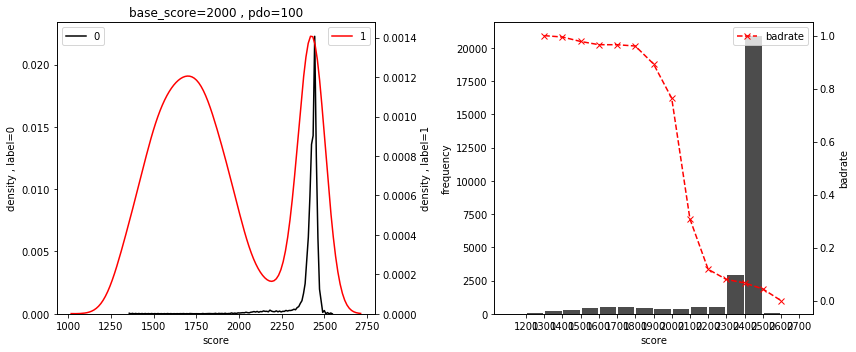

In [37]:
#样本为正例（坏样本）的概率转换分数
base_score=2000;pdo=100#概率转换分数的参数相关修改，改这里即可
df1521=train_data[['label']]
df1521['proba']=proba_train_20
df1521['score']=df1521['proba'].map(lambda x:proba_2score(x,base_score=base_score,pdo=pdo))
#分数分段
bin1521=np.linspace(1100,2700,17)
df1521['bins']=pd.cut(df1521['score'],bins=bin1521,labels=bin1521[1:])
#区分好坏样本绘制分数分布
fig1521,ax1521=plt.subplots(1,2,figsize=(6*2,5*1))
sns.distplot(df1521['score'][df1521.label==0],color='k',hist=False,ax=ax1521[0],label='0')
ax1521set0=ax1521[0].set(xlabel='score',ylabel='density , label=0',title='base_score=%s , pdo=%s'%(base_score,pdo))
ax1521[0].legend(loc=2)

ax152101=ax1521[0].twinx()
sns.distplot(df1521['score'][df1521.label==1],color='r',hist=False,ax=ax152101,label='1')
ax1521set01=ax152101.set(ylabel='density , label=1')
ax152101.legend(loc=0)
#直方图
ax1521[1].hist(df1521['score'],bins=bin1521,rwidth=0.9,color='k',alpha=0.7)
ax1521set1=ax1521[1].set(xticks=bin1521[1:],xlabel='score',ylabel='frequency')
plt.xticks(rotation=90)
#分数段间badrate单调性
ax1522=ax1521[1].twinx()
regroup1521=bin_badrate(df1521,'bins','label')['badrate']
ax1522.plot(bin1521[1:],regroup1521,'r--x',label='badrate')
ax1522set=ax1522.set(ylabel='badrate')
ax1522.legend(loc='best')
plt.tight_layout()


GBDT网格调参

'''
用于调参的变量：重要性前20.
集成模型GBDT可调参数比较多，若一次性使用所有参数网格调参，计算量太大，若允许损失部分性能，可参考以下顺序分步调参。
1、n_estimators:基模型个数；
2、max_depth、min_samples_split：树深、树内部分裂节点最小样本数；
3、min_samples_split、min_samples_leaf：树内部分裂节点最小样本数、树叶节点最小样本数；
4、max_features：寻找最佳分裂节点时使用的特征数量；
5、subsample：子采样。
'''
feat_gbdt=var_desc[:20]
x_train_search=train_data[feat_gbdt]
y_train_seaech=train_data.label

x_test_search=test_data[feat_gbdt]
y_test_search=test_data.label

param1={'n_estimators':range(80,151,10)}
base_estimator1=GradientBoostingClassifier(learning_rate=0.1,subsample=0.8,
                max_depth=3,min_samples_split=30,min_samples_leaf=5,max_features='sqrt',random_state=16)
gsearch1=GridSearchCV(base_estimator1,param_grid=param1,cv=10,scoring='roc_auc')
gsearch1.fit(x_train_search,y_train_seaech)
best_n_estimators=gsearch1.best_params_['n_estimators']
print('best_n_estimators:%s'%best_n_estimators)

param2={'max_depth':range(2,8),'min_samples_split':range(10,81,5)}
base_estimator2=GradientBoostingClassifier(n_estimators=best_n_estimators,learning_rate=0.1,subsample=0.8,
                min_samples_leaf=5,max_features='sqrt',random_state=16)
gsearch2=GridSearchCV(base_estimator2,param_grid=param2,cv=10,scoring='roc_auc')
gsearch2.fit(x_train_search,y_train_seaech)
best_depth=gsearch2.best_params_['max_depth']
best_samples_split=gsearch2.best_params_['min_samples_split']
print('best_depth:%s,best_samples_split:%s'%(best_depth,best_samples_split))

param3={'min_samples_split':range(40,81,5),'min_samples_leaf':range(5,20)}
base_estimator3=GradientBoostingClassifier(n_estimators=best_n_estimators,learning_rate=0.1,subsample=0.8,
                max_depth=best_depth,max_features='sqrt',random_state=16)
gsearch3=GridSearchCV(base_estimator3,param_grid=param3,cv=10,scoring='roc_auc')
gsearch3.fit(x_train_search,y_train_seaech)
best_samples_split=gsearch3.best_params_['min_samples_split']
best_samples_leaf=gsearch3.best_params_['min_samples_leaf']
print('best_samples_split:%s,best_samples_leaf:%s'%(best_samples_split,best_samples_leaf))

param4={'max_features':range(5,21)}
base_estimator4=GradientBoostingClassifier(n_estimators=best_n_estimators,learning_rate=0.1,subsample=0.8,
                        max_depth=best_depth,min_samples_split=best_samples_split,
                        min_samples_leaf=best_samples_leaf,random_state=16)
gsearch4=GridSearchCV(base_estimator4,param_grid=param4,cv=10,scoring='roc_auc')
gsearch4.fit(x_train_search,y_train_seaech)
best_features=gsearch4.best_params_['max_features']
print('best_features:%s'%best_features)

param5={'subsample':np.linspace(0.6,1,9)}
base_estimator5=GradientBoostingClassifier(n_estimators=best_n_estimators,learning_rate=0.1,
            max_depth=best_depth,min_samples_split=best_samples_split,min_samples_leaf=best_samples_leaf,
            max_features=best_features,random_state=16)
gsearch5=GridSearchCV(base_estimator5,param_grid=param5,cv=10,scoring='roc_auc')
gsearch5.fit(x_train_search,y_train_seaech)
best_samples=gsearch5.best_params_['subsample']
print('best_samples：%s'%best_samples)
